In [1]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"blake2703","key":"c27f1fb794b95e2758df4fa12ede812d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

flickr-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import *

file_name = 'flickr-image-dataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Files Extracted')

Files Extracted


In [6]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('all')

In [ ]:
pip install tensorflow-text 

In [ ]:
pip install tensorflow-hub

In [ ]:
pip install pandas

In [ ]:
pip install seaborn

In [ ]:
pip install scikit-learn

In [ ]:
pip install matplotlib

In [ ]:
pip install nltk

In [ ]:
pip install numpy

In [7]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import contractions
import string
from collections import Counter
from sklearn.model_selection import train_test_split

## 1.0 Get Data and Greet Data

A dataset should be broken up into multiple datasets:
- data_raw = first read in of our data, but will not be touched
- data_copy = data_raw copied, which will be used to clean, feature engineer, and wrangle our data

In [8]:
data_raw = pd.read_csv('/content/flickr30k_images/results.csv', delimiter='|')
data_copy = pd.read_csv('/content/flickr30k_images/results.csv', delimiter='|')

In [9]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   image_name       158915 non-null  object
 1    comment_number  158915 non-null  object
 2    comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


We notice that we have a missing value in the comment section. This will be important to us as we clean our data later. The other two columns look like they do not have any missing data.

In [10]:
data_raw.sample(10)

,image_name,comment_number,comment
11659,172892648.jpg,4,A person is breaking trail on a snowy hill .
33229,2534424894.jpg,4,A little girl is jumping down a sandy hill .
112107,4704939941.jpg,2,Man in his seventies wearing a colorful outfi...
100086,4463538995.jpg,1,A person in a red jacket with black pants hol...
44544,2819254573.jpg,4,A young boy screams on a roller coaster .
76363,3559357704.jpg,3,A red race car going down a dirt road with a ...
75910,3549408779.jpg,0,A small black and white dog paddles in some c...
113652,4727583716.jpg,2,Farmers line up and tend to their cattle .
129670,4992006407.jpg,0,A black man takes a shot at a pool table whil...
79210,3623894108.jpg,0,A statue of an Indian is on the sidewalk in f...


Our data is structured with three columns:
- image_name: which is the unique tag of the image
- comment_number: which is the specific comment number about the image
- comment: this is the actual comment left about the image <br><br>

We expect to see 5 comments per uniuqe image_id so let's make sure that is the case:

In [11]:
image_name_unique_vals = data_raw['image_name'].unique().tolist()
print("Total length of unique values: ", len(image_name_unique_vals))
print("Total length of data frame: ",  len(data_raw))
print("Total length of unique values * 5: ", len(image_name_unique_vals) * 5)

Total length of unique values:  31783
Total length of data frame:  158915
Total length of unique values * 5:  158915


Based off our findings above, we can see that there are in fact 31,783 unique images in the dataset, corresponding to 158,915 in the total dataset, so in fact we do have 5 comments per image.

### 1.1 The 4 C's of Data Cleaning: Correction, Completing, Creating, and Converting <br><br>

In this stage, we will clean our data by:
1. correcting values and outliers 
2. completing missing information
3. creating new features for analysis
4. converting fields to the correct format for calculations and presentation.

#### 1.1.1 Correcting data

In [12]:
print('Columns with null values:')
print(data_copy.isnull().sum())

Columns with null values:
image_name         0
 comment_number    0
 comment           1
dtype: int64


In [13]:
data_copy.describe(include = 'all').transpose()

,count,unique,top,freq
image_name,158915,31783,1000092795.jpg,5
comment_number,158915,6,0,31783
comment,158914,158438,Two dogs playing in the snow .,7


First, let's make sure that our columns are formatted correctly so we can pull data from them:

In [51]:
data_copy.columns

Index(['image_name', 'comment_number', 'comment', 'char_count', 'word_count',
       'sentence_count', 'unique_word_count', 'average_word_length',
       'average_sentence_length', 'unique_words_vs_words', 'label'],
      dtype='object')

In [15]:
data_copy.columns = data_copy.columns.str.replace(' ', '')
data_copy.columns

Index(['image_name', 'comment_number', 'comment'], dtype='object')

Let's take a look at the comment_number issue because we should have 5 unique comment_numbers not 6:

In [16]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print(comment_number_unique_vals)

[' 0', ' 1', ' 2', ' 3', ' 4', ' 4   A dog runs across the grass .']


Let's see if this last item in the list above correlates with our missing value in the comment column because it seems to have a number and a sentence combined into one:

In [17]:
data_copy[data_copy['comment'].isnull()]

,image_name,comment_number,comment
19999,2199200615.jpg,4 A dog runs across the grass .,NaN


In [18]:
#Filter location to where the data is missing a value
data_copy[data_copy['image_name'] == '2199200615.jpg']
#Create a temporary variable to hold that row
tmp = data_copy.iloc[19999]

#Get the comment number column
holder = tmp['comment_number']

#Seperate the text from the digit and print
result = ''.join([i for i in holder if not i.isdigit()])

#Update the temporary variable row
tmp['comment'] = result 
tmp['comment_number'] = '4'

#Update our data copy row to reflect change
data_copy.iloc[19999] = tmp
print(data_copy.iloc[19999])

image_name                           2199200615.jpg
comment_number                                    4
comment               A dog runs across the grass .
Name: 19999, dtype: object


In [19]:
print('Updated Columns with null values:') 
print(data_copy.isnull().sum())

Updated Columns with null values:
image_name        0
comment_number    0
comment           0
dtype: int64


In [20]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print(comment_number_unique_vals)

[' 0', ' 1', ' 2', ' 3', ' 4', '4']


In [21]:
data_copy['comment_number'] = data_copy['comment_number'].str.lstrip()

In [22]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
print(comment_number_unique_vals)

['0', '1', '2', '3', '4']


We should also clean our sentences:
1. Remove punctuations
    - Ex:
        - i am happy. -> i am happy
2. Lower case all the data
    - Ex:
        - I AM HAPPY -> i am happy
3. Remove emojis
    - Ex:
        - 🫠 -> ''
4. Remove contractions
    - Ex:
        - I didn't do well -> I did not do well
5. Remove extra whitespace
    - Ex:
        - ' i am happy ' -> 'i am happy'
6. Deal with stopwords
    - In this case I am going to remove them. Stopwords are words that are automatically omitted from a computer-generated index.
    - Ex:
        - "I", "a", "the"
    - We may want to consider adding our own stopwords we see a lot of to the mix



In [23]:
def expand_contractions(comment):
    """
    This function will expand all contractions to get rid of them.

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
       Object: A fixed object that has all the punctuations taken out of the sentence
    """
    comment = contractions.fix(comment)
    return comment
data_copy['comment'] = data_copy['comment'].apply(expand_contractions)

In [24]:
def remove_punctuations(comment):
    """
    This function will go through all the comment rows and remove all punctuations.
    
    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    for letter in string.punctuation:
        comment = comment.replace(letter, '')
    return comment
#call function on dataframe to remove punctuations
data_copy['comment'] = data_copy['comment'].apply(remove_punctuations)

In [25]:
#convert all letters in the comment column to lowercase
data_copy['comment'] = data_copy['comment'].str.lower()

In [26]:
#remove all emojis from the comment column
data_copy.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

,image_name,comment_number,comment
0,1000092795.jpg,0,two young guys with shaggy hair look at their...
1,1000092795.jpg,1,two young white males are outside near many ...
2,1000092795.jpg,2,two men in green shirts are standing in a yard
3,1000092795.jpg,3,a man in a blue shirt standing in a garden
4,1000092795.jpg,4,two friends enjoy time spent together
...,...,...,...
158910,998845445.jpg,0,a man in shorts and a hawaiian shirt leans ov...
158911,998845445.jpg,1,a young man hanging over the side of a boat ...
158912,998845445.jpg,2,a man is leaning off of the side of a blue an...
158913,998845445.jpg,3,a man riding a small boat in a harbor with f...


In [27]:
#get rid of all whitespace in the comment column
data_copy['comment'] = data_copy['comment'].str.strip()

Now let's find out what the most common words are from each sentence:

In [28]:
Counter(" ".join(data_copy["comment"]).split()).most_common(100)

[('a', 271705),
 ('in', 83466),
 ('the', 62982),
 ('on', 45669),
 ('and', 44263),
 ('man', 42598),
 ('is', 41146),
 ('of', 38779),
 ('with', 36207),
 ('woman', 22211),
 ('two', 21642),
 ('are', 20211),
 ('to', 17609),
 ('people', 17337),
 ('at', 16259),
 ('an', 15883),
 ('wearing', 15709),
 ('young', 13218),
 ('white', 13178),
 ('shirt', 12981),
 ('black', 12311),
 ('while', 11711),
 ('his', 11495),
 ('blue', 11310),
 ('red', 9916),
 ('girl', 9655),
 ('sitting', 9620),
 ('men', 9498),
 ('boy', 9429),
 ('standing', 9113),
 ('dog', 9090),
 ('playing', 8620),
 ('street', 7998),
 ('group', 7852),
 ('down', 7678),
 ('front', 7604),
 ('her', 7414),
 ('walking', 7339),
 ('holding', 6985),
 ('one', 6484),
 ('water', 5957),
 ('by', 5771),
 ('three', 5770),
 ('women', 5275),
 ('green', 5221),
 ('up', 5114),
 ('child', 5078),
 ('looking', 5067),
 ('as', 5028),
 ('for', 4899),
 ('little', 4794),
 ('large', 4753),
 ('outside', 4702),
 ('yellow', 4557),
 ('person', 4479),
 ('children', 4454),
 ('bro

In [30]:
stop = stopwords.words('english') #assign all stopwords to variable stop
data_copy['comment'] = data_copy['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #remove stopwords

With stopwords removed, here are the most common words:

In [31]:
Counter(" ".join(data_copy["comment"]).split()).most_common(100)

[('man', 42598),
 ('woman', 22211),
 ('two', 21642),
 ('people', 17337),
 ('wearing', 15709),
 ('young', 13218),
 ('white', 13178),
 ('shirt', 12981),
 ('black', 12311),
 ('blue', 11310),
 ('red', 9916),
 ('girl', 9655),
 ('sitting', 9620),
 ('men', 9498),
 ('boy', 9429),
 ('standing', 9113),
 ('dog', 9090),
 ('playing', 8620),
 ('street', 7998),
 ('group', 7852),
 ('front', 7604),
 ('walking', 7339),
 ('holding', 6985),
 ('one', 6484),
 ('water', 5957),
 ('three', 5770),
 ('women', 5275),
 ('green', 5221),
 ('child', 5078),
 ('looking', 5067),
 ('little', 4794),
 ('large', 4753),
 ('outside', 4702),
 ('yellow', 4557),
 ('person', 4479),
 ('children', 4454),
 ('brown', 4446),
 ('hat', 4037),
 ('ball', 3892),
 ('small', 3779),
 ('next', 3752),
 ('dressed', 3462),
 ('another', 3372),
 ('running', 3369),
 ('building', 3360),
 ('jacket', 3348),
 ('riding', 3313),
 ('around', 3134),
 ('orange', 3086),
 ('near', 3016),
 ('field', 2981),
 ('crowd', 2963),
 ('stands', 2935),
 ('beach', 2904),


#### 1.1.2 Creating

Here we will be using feature engineering:
- Count number of characters
- Count number of words
- Count number of capital characters
- Count number of capital words
- Count number of punctuations
- Count number of words in quotes
- Count number of sentences
- Count number of unique words
- Count special characters
- Count stopwords
- Calculate average word length
- Calculate average sentence length
- Unique word count vs word count
- Stopword count vs word count

In [32]:
def count_chars(comment): 
    """
    This function will count the amount of characters in each comment

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    return len(comment)



def count_words(comment):
    """
    This function will count the amount of words in each comment

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    return len(comment.split()) #split the string on each space


#need this line for some reason
nltk.download('punkt')
def count_sentences(comment):
    """
    This function will count the amount of sentences in each comment

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    return len(nltk.sent_tokenize(comment))


def count_unique_words(comment):
    """
    This function will count the amount of unique words in a comment

    Args:
        comment (object): A column in the dataframe that contains all the comments from each image

    Returns:
        Object: A fixed object that has all the punctuations taken out of the sentence
    """
    return len(set(comment.split()))




def calc_avg_word_length(num_chars, num_words):
    """
    This function will calculate the average word length per sentence

    Args:
        num_chars (int): number of chars per word
        num_words (int): number of words per sentence

    Returns:
        Float: the average word length per setence
    """
    return num_chars/num_words


def calc_avg_sentence_length(num_words, num_sentences):
    """
    This function will calculate the average sentence length per comment

    Args:
        num_words (int): number of words per comment
        num_sentences (int): number of sentences per comment

    Returns:
        Float: the average sentence length per comment
    """
    return num_words/num_sentences

def count_unique_words_vs_word_count(num_words, num_unique):
    """
    This function will count the number of unique words vs the total words per sentence

    Args:
        num_words (int): number of words per sentence
        num_unique (int): number of unique words per sentence

    Returns:
        Float: the ratio of unique words to total words
    """
    return num_unique/num_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
data_copy['char_count'] = data_copy['comment'].apply(lambda x : count_chars(x))
data_copy['word_count'] = data_copy['comment'].apply(lambda x : count_words(x))
data_copy['sentence_count'] = data_copy['comment'].apply(lambda x : count_sentences(x))
data_copy['unique_word_count'] = data_copy['comment'].apply(lambda x : count_unique_words(x))
data_copy['average_word_length'] = data_copy['char_count']/data_copy['word_count']
data_copy['average_sentence_length'] = data_copy['word_count']/data_copy['sentence_count']
data_copy['unique_words_vs_words'] = data_copy['unique_word_count']/data_copy['word_count']

In [34]:
data_copy.columns

Index(['image_name', 'comment_number', 'comment', 'char_count', 'word_count',
       'sentence_count', 'unique_word_count', 'average_word_length',
       'average_sentence_length', 'unique_words_vs_words'],
      dtype='object')

## 2.0 EDA

### 2.1.1 Analyzing Character Counts

In [54]:
def plot_hist(x_size, y_size, facecolor, x_axis, edgecolor, bar_color, x_label, y_label, title):
    """
    Args:
        x_size (int): x_axis size for figsize
        y_size (int): y_axis size for figsize
        facecolor (string): Hex value for the facecolor of graph
        x_axis (object): Column of the dataframe to graph
        edgecolor (string): Hex value for the edge color of histogram bins
        bar_color (string): Hex value for the bar color of the histogram
        x_label (string): x_axis title
        y_label (string): y_axis title
        title (string): The title of the graph
    """
    plt.figure(figsize=(x_size, y_size))
    plt.rcParams['axes.facecolor'] = facecolor
    plt.rcParams['figure.facecolor'] = facecolor
    #using Sturge's rule to calculate number of bins
    bin_count = int(np.ceil(np.log2(len(data_copy))) + 1)
    values, bins, bars = plt.hist(x_axis, bin_count, edgecolor=edgecolor, facecolor=bar_color, alpha=1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # plt.bar_label(bars, fontsize=10, color='black')
    plt.margins(x=0.01, y=0.1)
    plt.grid(False)
    print("Displaying histogram with " + str(bin_count) + " bins.")

Displaying histogram with 19 bins.


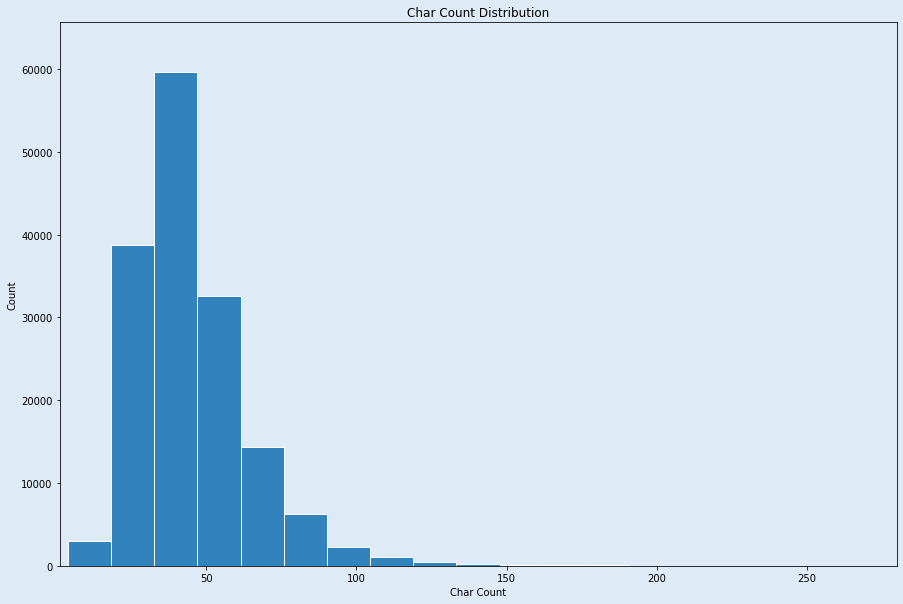

In [55]:
plot_hist(15,
          10,
          '#DEEBF7',
          data_copy['char_count'],
          'white',
          '#3182BD',
          'Char Count',
          'Count',
          'Char Count Distribution')

Based off our historgram distribution we can see that a majority of our data lies in bin 3. We used Sturge's rule to calculate the number of bins, in which we use the formula, $$[log_{2}n + 1]$$. <br><br> This formula uses **n** which is the total number of observations in the dataset and takes the log of that and adds 1. <br><br> Since our data peaks in bin 3 we can say that most of our data will range from roughly 29-44 characters. Adding on, our data is skewed right as we see that there is a little bit of a tail to the right of the graph. This means that the mean is greater than the median.

### 2.1.1 Analyzing Word Counts

Displaying histogram with 19 bins.


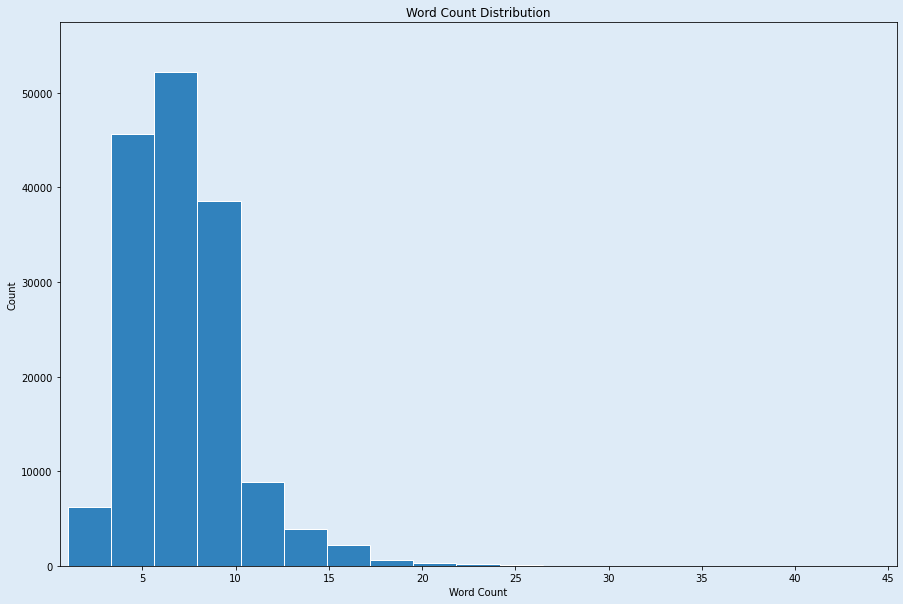

In [56]:
plot_hist(15,
          10,
          '#DEEBF7',
          data_copy['word_count'],
          'white',
          '#3182BD',
          'Word Count',
          'Count',
          'Word Count Distribution')

## 3.0 Model 1 (Baseline)
1. Create a temporary dataframe in order to shrink our dataset down because it takes forever to train
2. remove .jpg from image name column
3. label each image
4. split into validation and train datasets (must do this on every run in order to avoid overfitting)
5. encode each sentence (give each character a token)
6. build and run model

How to improve?
1. run more epochs
2. train on more data
3. clean data differently
4. add more layers
5. change activation function
6. change hyperparameters

Creating a temporary data frame for our model to run our testing on:

In [35]:
tmp = data_copy

In [57]:
#Remove '.jpg' from image
tmp['image_name'] = tmp['image_name'].str.replace('.jpg', '')
tmp['image_name'].astype(str)

<ipython-input-57-8a8f9df5ab3e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tmp['image_name'] = tmp['image_name'].str.replace('.jpg', '')


0         1000092795
1         1000092795
2         1000092795
3         1000092795
4         1000092795
             ...    
158910     998845445
158911     998845445
158912     998845445
158913     998845445
158914     998845445
Name: image_name, Length: 158915, dtype: object

In [37]:
#temporary df until final model is built
temp33 = tmp
dic = dict()
label_list = list()
#create new column label to label each picture to a numeric digit representing a class
temp33['label'] = np.nan


def classify_images(df):
  '''
    A function to turn the images to a label classifying them

    Args: 
        df: a dataframe
    
'''
    #temporary counting variable
    temp_counter = 0
    #loop through each image in the image_name column
    for value in df['image_name']:
        #assign the counter as the value while the image_name is the key
        if value not in dic:
            dic[value] = temp_counter
            temp_counter+=1
    #put the image_name column values in a list
    images = temp33['image_name'].tolist()
    #loop through the image list and append the correct counter
    for image in images:
        label_list.append(dic[image])
    #update label column to the correct value
    temp33['label'] = label_list

classify_images(temp33)

#make sure output is correct
temp33.tail()

,image_name,comment_number,comment,char_count,word_count,sentence_count,unique_word_count,average_word_length,average_sentence_length,unique_words_vs_words,label
158910,998845445,0,man shorts hawaiian shirt leans rail pilot boa...,72,11,1,11,6.545455,11.0,1.0,31782
158911,998845445,1,young man hanging side boat like fog rolling h...,56,10,1,10,5.600000,10.0,1.0,31782
158912,998845445,2,man leaning side blue white boat sits body water,48,9,1,9,5.333333,9.0,1.0,31782
158913,998845445,3,man riding small boat harbor fog mountains bac...,53,8,1,8,6.625000,8.0,1.0,31782
158914,998845445,4,man moored blue white boat hills mist background,48,8,1,8,6.000000,8.0,1.0,31782


Shrink dataset to test our baseline model:

In [38]:
temp33 = temp33[:500]

In [40]:
y = tf.keras.utils.to_categorical(temp33["label"].values, num_classes=100)
x_train, x_test, y_train, y_test = train_test_split(temp33['comment'], y, test_size=0.30, random_state=101)

In [42]:
#Get the pretrained model from tensorflow
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

In [43]:
get_embeddings([
    "Two men in green shirts are standing in a yard ."]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-1.00979418e-01, -2.40859687e-01, -3.70999545e-01,
        -3.99186075e-01,  5.18987119e-01,  1.63879320e-01,
        -6.19030058e-01, -1.53649926e+00, -3.58318776e-01,
        -4.50376779e-01, -5.79445422e-01, -2.37727344e-01,
         4.66266721e-02, -2.69735307e-01, -5.10573447e-01,
        -1.77771056e+00,  4.96257156e-01,  7.45594725e-02,
         8.19619119e-01, -4.14289951e-01,  1.72468454e-01,
        -3.21447223e-01, -3.11370455e-02,  5.61242044e-01,
        -3.37898523e-01, -2.64109135e+00,  5.65499187e-01,
        -3.92092496e-01, -2.10578069e-01, -2.13105276e-01,
        -7.36145079e-02, -2.81442165e-01, -4.69811738e-01,
        -6.55143619e-01, -4.47638333e-01,  2.10718334e-01,
        -9.76391658e-02,  5.24663448e-01,  3.80600780e-01,
         1.03424285e-02, -1.38647303e-01, -4.79550987e-01,
        -3.63018483e-01,  2.93420583e-01, -4.72150505e-01,
         1.56606928e-01,  3.67023349e-01,  4.11950350e-02,
      

In [44]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(100, activation='softmax', name="output")(x)
model = tf.keras.Model(i, x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [45]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),  
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback],
                      shuffle=True)

Epoch 1/20
11/11 [==============================] - 40s 1s/step - loss: 4.8926 - accuracy: 0.0171 - val_loss: 4.7552 - val_accuracy: 0.0267
Epoch 2/20
11/11 [==============================] - 12s 1s/step - loss: 4.2876 - accuracy: 0.0943 - val_loss: 4.5596 - val_accuracy: 0.0533
Epoch 3/20
11/11 [==============================] - 7s 600ms/step - loss: 3.9156 - accuracy: 0.2114 - val_loss: 4.3652 - val_accuracy: 0.1133
Epoch 4/20
11/11 [==============================] - 7s 685ms/step - loss: 3.5728 - accuracy: 0.3486 - val_loss: 4.1433 - val_accuracy: 0.1667
Epoch 5/20
11/11 [==============================] - 6s 548ms/step - loss: 3.2449 - accuracy: 0.5657 - val_loss: 3.9315 - val_accuracy: 0.2667
Epoch 6/20
11/11 [==============================] - 7s 696ms/step - loss: 2.9719 - accuracy: 0.6571 - val_loss: 3.7535 - val_accuracy: 0.3333
Epoch 7/20
11/11 [==============================] - 6s 551ms/step - loss: 2.6508 - accuracy: 0.7857 - val_loss: 3.5644 - val_accuracy: 0.4067
Epoch 8/20

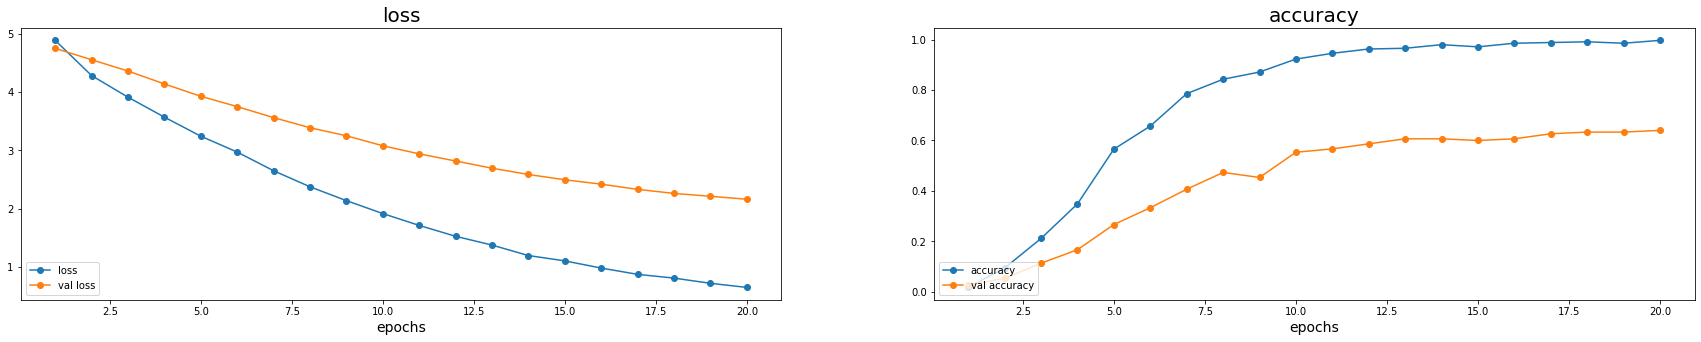

In [46]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [48]:
temp33.head(30)

,image_name,comment_number,comment,char_count,word_count,sentence_count,unique_word_count,average_word_length,average_sentence_length,unique_words_vs_words,label
0,1000092795,0,two young guys shaggy hair look hands hanging ...,50,9,1,9,5.555556,9.0,1.000000,0
1,1000092795,1,two young white males outside near many bushes,46,8,1,8,5.750000,8.0,1.000000,0
2,1000092795,2,two men green shirts standing yard,34,6,1,6,5.666667,6.0,1.000000,0
3,1000092795,3,man blue shirt standing garden,30,5,1,5,6.000000,5.0,1.000000,0
4,1000092795,4,two friends enjoy time spent together,37,6,1,6,6.166667,6.0,1.000000,0
5,10002456,0,several men hard hats operating giant pulley s...,51,8,1,8,6.375000,8.0,1.000000,1
6,10002456,1,workers look piece equipment,28,4,1,4,7.000000,4.0,1.000000,1
7,10002456,2,two men working machine wearing hard hats,41,7,1,7,5.857143,7.0,1.000000,1
8,10002456,3,four men top tall structure,27,5,1,5,5.400000,5.0,1.000000,1
9,10002456,4,three men large rig,19,4,1,4,4.750000,4.0,1.000000,1


In [50]:
reviews = [
    "two men cooking a meal",
    "two men stove preparing food",
    "two guys",
    "two men"
]

def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


predict_class(reviews)

1/1 [==============================] - 0s 78ms/step


[4, 4, 77, 77]

In [59]:
tmp[tmp['label'] == 77]

,image_name,comment_number,comment,char_count,word_count,sentence_count,unique_word_count,average_word_length,average_sentence_length,unique_words_vs_words,label
385,1021439420,0,two guys sitting floor guy green jacket readin...,59,10,1,10,5.900000,10.0,1.0,77
386,1021439420,1,elderly father grown son preparing camping tri...,52,8,1,8,6.500000,8.0,1.0,77
387,1021439420,2,two men sit floor camping equipment,35,6,1,6,5.833333,6.0,1.0,77
388,1021439420,3,two men sitting living floor,28,5,1,5,5.600000,5.0,1.0,77
389,1021439420,4,two guys sorting items,22,4,1,4,5.500000,4.0,1.0,77


Our model predicts two sentences correctly. The two that are correct are th sentences that match word for word. However on the two it mislabels we see that it still predicts a label with two men present. How can we improve??